In [2]:
# Instalar las librerias
# !pip install pandas
# !pip install scikit-learn
# D:\01_MaestriaAnalitica_UnivAndes\07_ML_NLP\S4\Proyecto\pry_pric_cars\venv\Scripts\pip.exe install -r requirements.txt
# !pip install imblearn

In [1]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import time

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

In [2]:
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

X = train_df.iloc[:,1:]
y = train_df.iloc[:,0]

#del(train_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape)
X_train.head(5)

(240000, 5)


,Year,Mileage,State,Make,Model
372565,2017,28148,VA,Jeep,PatriotLatitude
309294,2016,50252,OR,Ford,Explorer4WD
3074,2006,127862,VA,INFINITI,QX564WD
387027,2014,65618,TX,Land,Rover
122757,2014,40369,KY,Honda,Civic


In [3]:
train_df = X_train.copy()
train_df["Price"] = y

In [4]:
train_df.head(2)

,Year,Mileage,State,Make,Model,Price
372565,2017,28148,VA,Jeep,PatriotLatitude,17497
309294,2016,50252,OR,Ford,Explorer4WD,32999


In [5]:
categorical_cols = ["State","Make","Model","Year"]

for c in categorical_cols:
    gr = train_df.groupby(c)[["Price"]].count().reset_index().sort_values(by="Price", ascending = False)
    print(gr.describe())
    print(gr.shape)
    display(gr)

              Price
count     51.000000
mean    4705.882353
std     5586.161182
min        4.000000
25%     1196.500000
50%     2978.000000
75%     6446.500000
max    27686.000000
(51, 2)


,State,Price
43,TX,27686
4,CA,21747
9,FL,20221
10,GA,10998
27,NC,10688
14,IL,10256
45,VA,9508
38,PA,7762
34,NY,7546
31,NJ,7265


              Price
count     38.000000
mean    6315.789474
std     9358.655506
min        4.000000
25%      619.750000
50%     1933.500000
75%     8011.750000
max    37718.000000
(38, 2)


,Make,Price
10,Ford,37718
6,Chevrolet,34964
35,Toyota,27529
13,Honda,19899
17,Jeep,14683
12,GMC,12511
18,Kia,9889
8,Dodge,9725
14,Hyundai,8957
20,Lexus,8213


              Price
count    525.000000
mean     457.142857
std      816.012440
min       25.000000
25%       88.000000
50%      201.000000
75%      515.000000
max    10789.000000
(525, 2)


,Model,Price
417,Silverado,10789
248,Grand,7474
416,Sierra,4973
40,Accord,4344
187,F-1504WD,3944
...,...,...
339,PathfinderSE,30
515,Yaris4dr,30
383,RegalGS,29
303,Monte,27


              Year         Price
count    22.000000     22.000000
mean   2007.500000  10909.090909
std       6.493587  13706.719183
min    1997.000000     62.000000
25%    2002.250000    522.250000
50%    2007.500000   5332.500000
75%    2012.750000  17494.000000
max    2018.000000  42837.000000
(22, 2)


,Year,Price
18,2015,42837
17,2014,40761
19,2016,33631
20,2017,27029
16,2013,19329
15,2012,18548
14,2011,14332
13,2010,9888
11,2008,8158
10,2007,6633


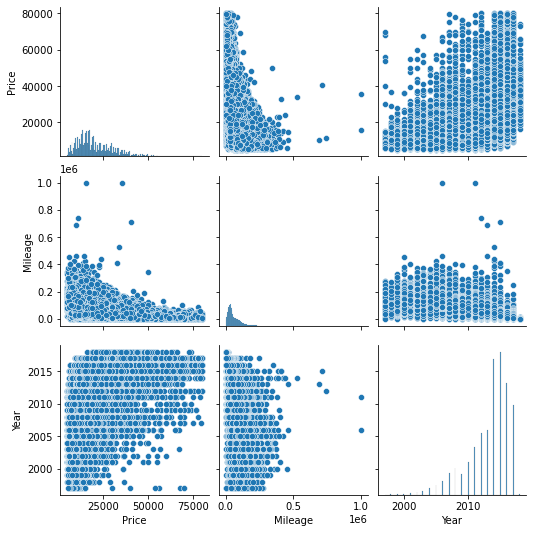

In [6]:
continuous_cols = ["Price","Mileage","Year"]
sns.pairplot(train_df[continuous_cols])

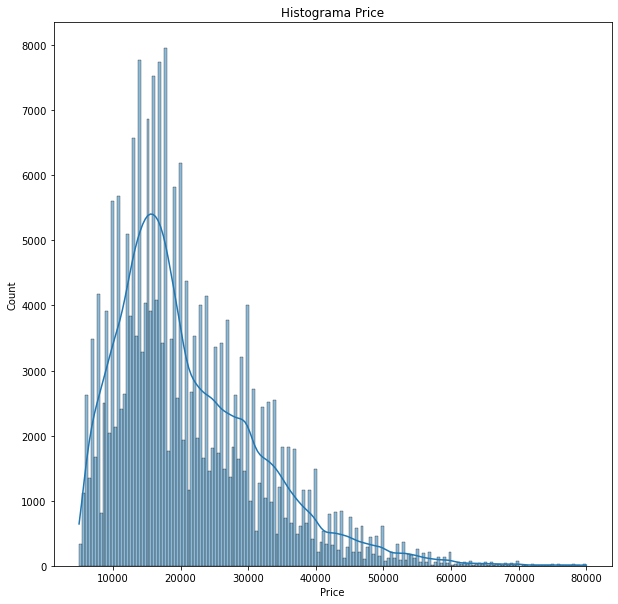

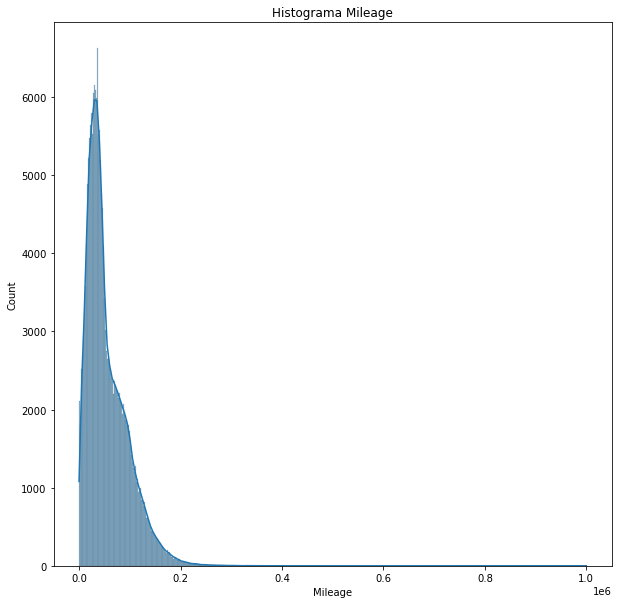

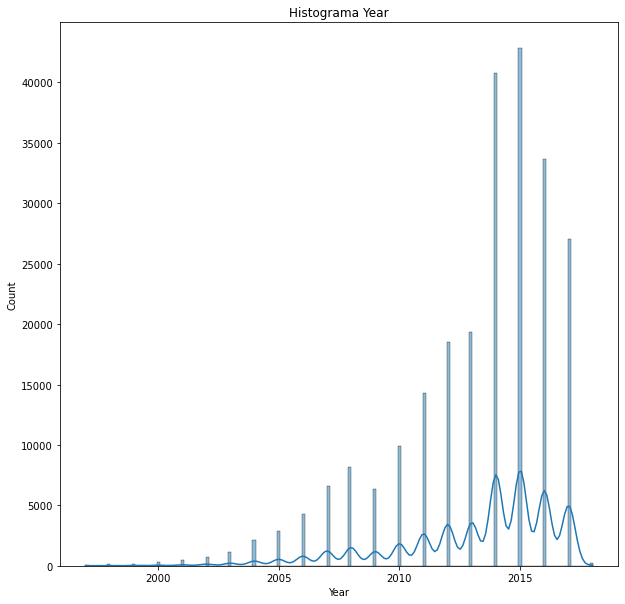

In [7]:
for c in continuous_cols:
    fig, ax = plt.subplots(figsize=(10,10))
    sns.histplot(data=train_df, x=c, kde=True, ax = ax)
    ax.set_title("Histograma {}".format(c))

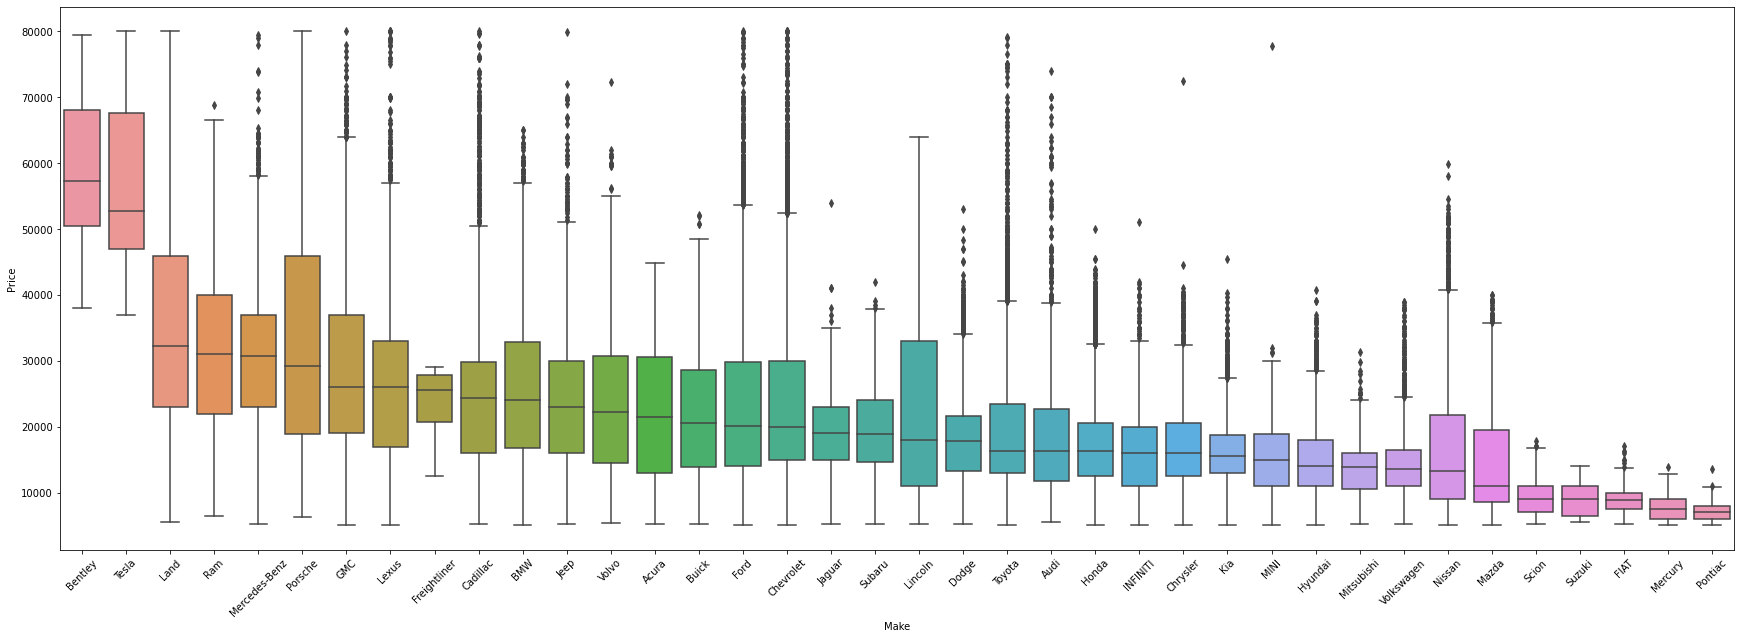

In [8]:
fig, ax = plt.subplots(figsize=(30,10))

violin_order = train_df.groupby("Make")[["Price"]].median().reset_index().sort_values(by="Price", ascending=False)["Make"]

sns.boxplot(data=train_df, x="Make", y="Price", order=violin_order)
plt.xticks(rotation=45);

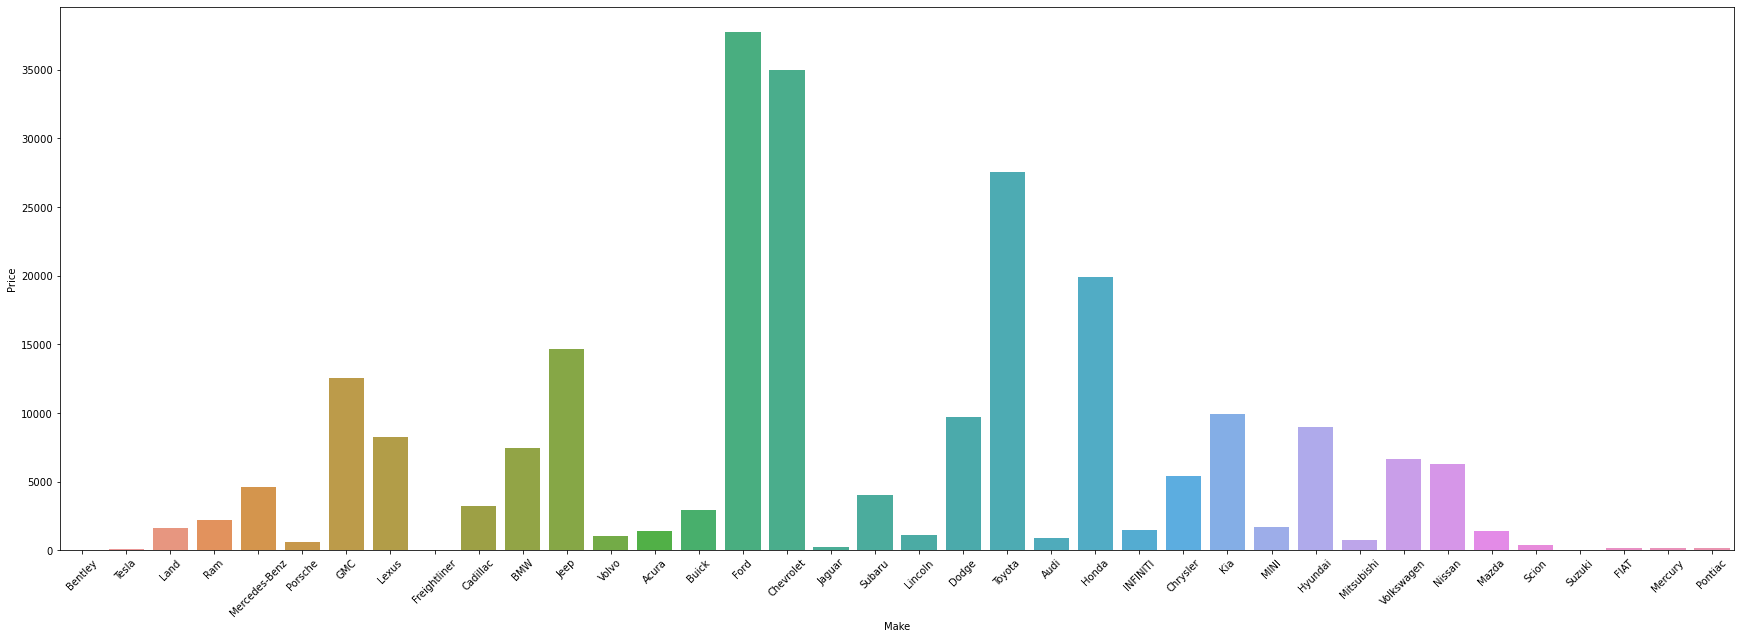

In [9]:
gr = train_df.groupby("Make")[["Price"]].count().reset_index().sort_values(by="Price", ascending = False)
fig, ax = plt.subplots(figsize=(30,10))

sns.barplot(data=gr, x = "Make", y= "Price",order=violin_order)
plt.xticks(rotation=45);

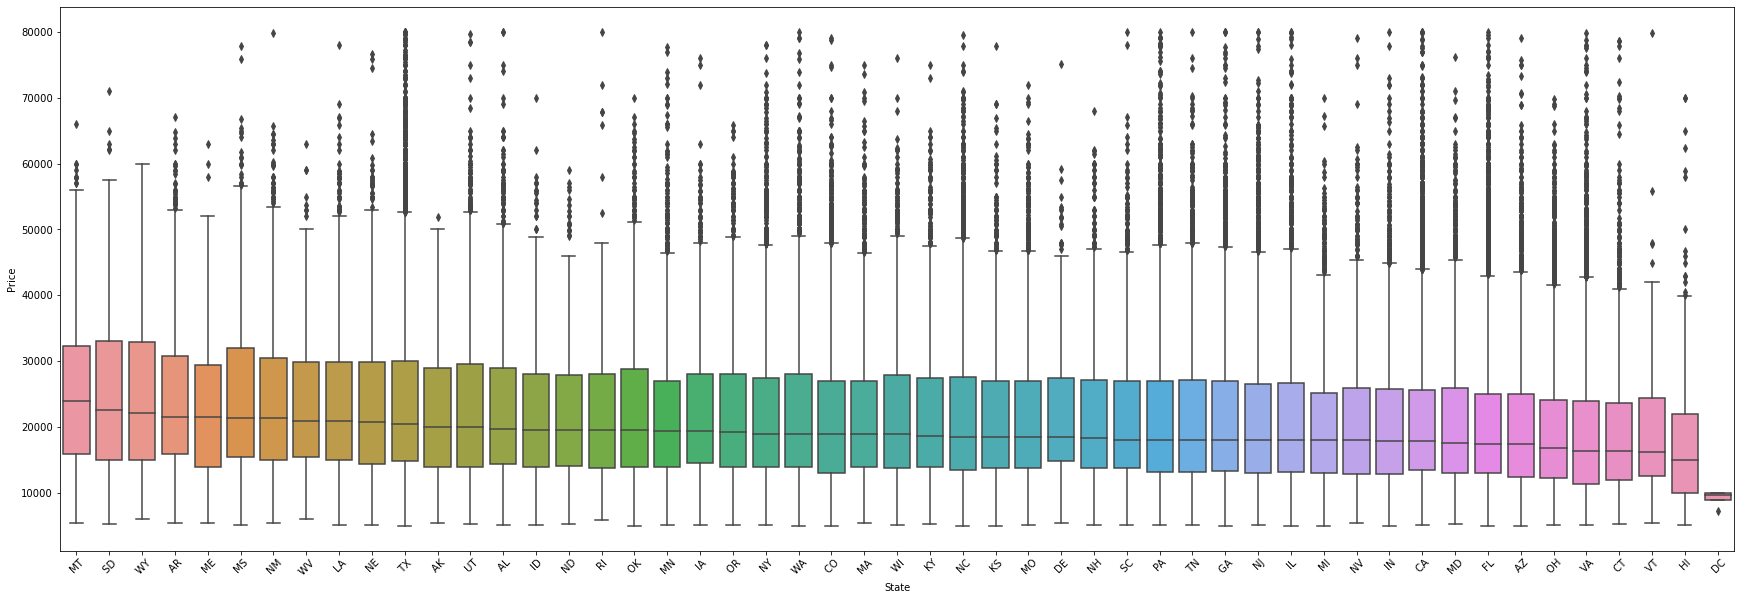

In [10]:
fig, ax = plt.subplots(figsize=(30,10))

violin_order = train_df.groupby("State")[["Price"]].median().reset_index().sort_values(by="Price", ascending=False)["State"]

sns.boxplot(data=train_df, x="State", y="Price", order=violin_order)
plt.xticks(rotation=45);

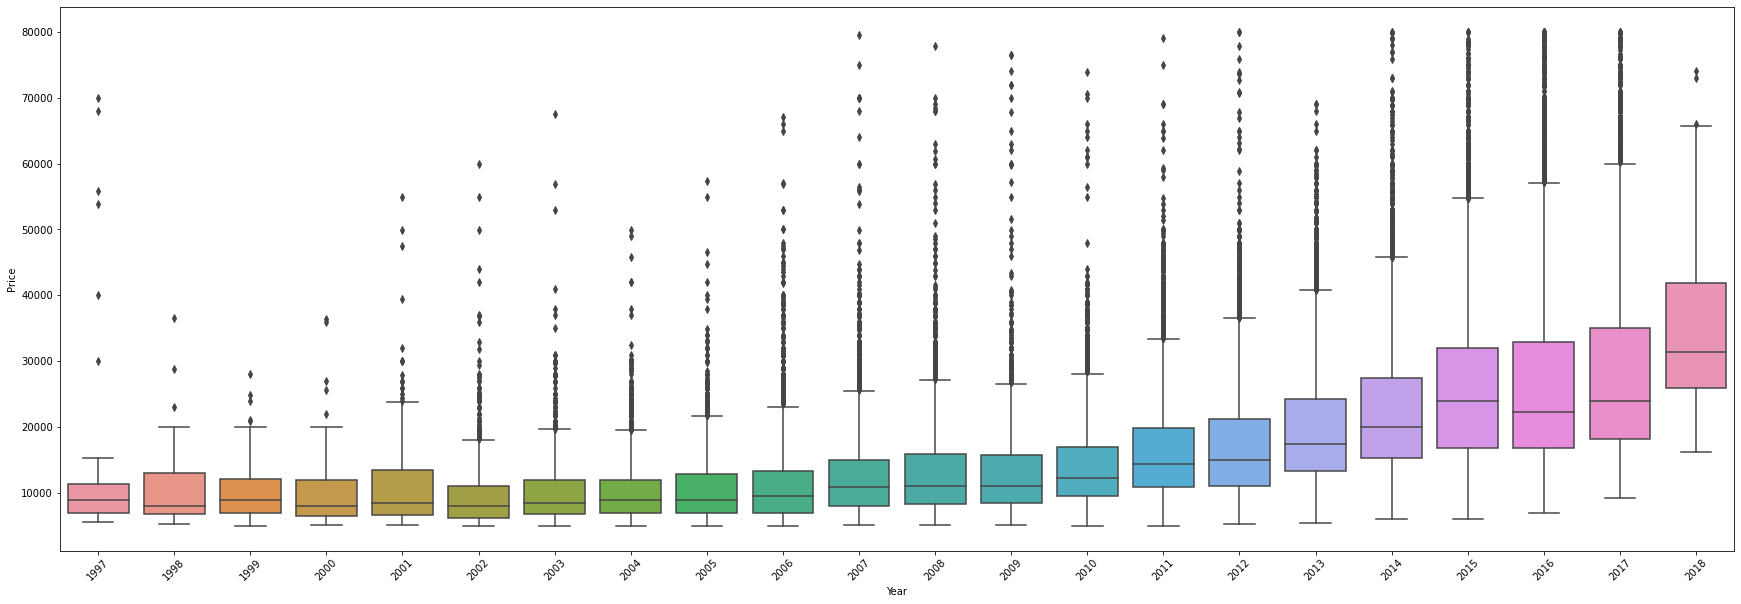

In [11]:
fig, ax = plt.subplots(figsize=(30,10))

sns.boxplot(data=train_df, x="Year", y="Price")
plt.xticks(rotation=45);

In [12]:
train_df.groupby(["Make","Model"])[["Price"]].median().reset_index().sort_values(by="Price", ascending=False).head(29)

,Make,Model,Price
25,Bentley,Continental,57260.0
468,Toyota,Land,54961.0
191,Ford,MustangShelby,52900.0
437,Tesla,Model,52688.0
361,Mercedes-Benz,E-ClassE,52203.5
535,Volvo,XC90T6,51030.0
59,Chevrolet,CorvetteConvertible,49995.0
60,Chevrolet,CorvetteCoupe,48294.0
334,Lexus,LXLX,46795.5
216,GMC,Yukon4WD,46424.5


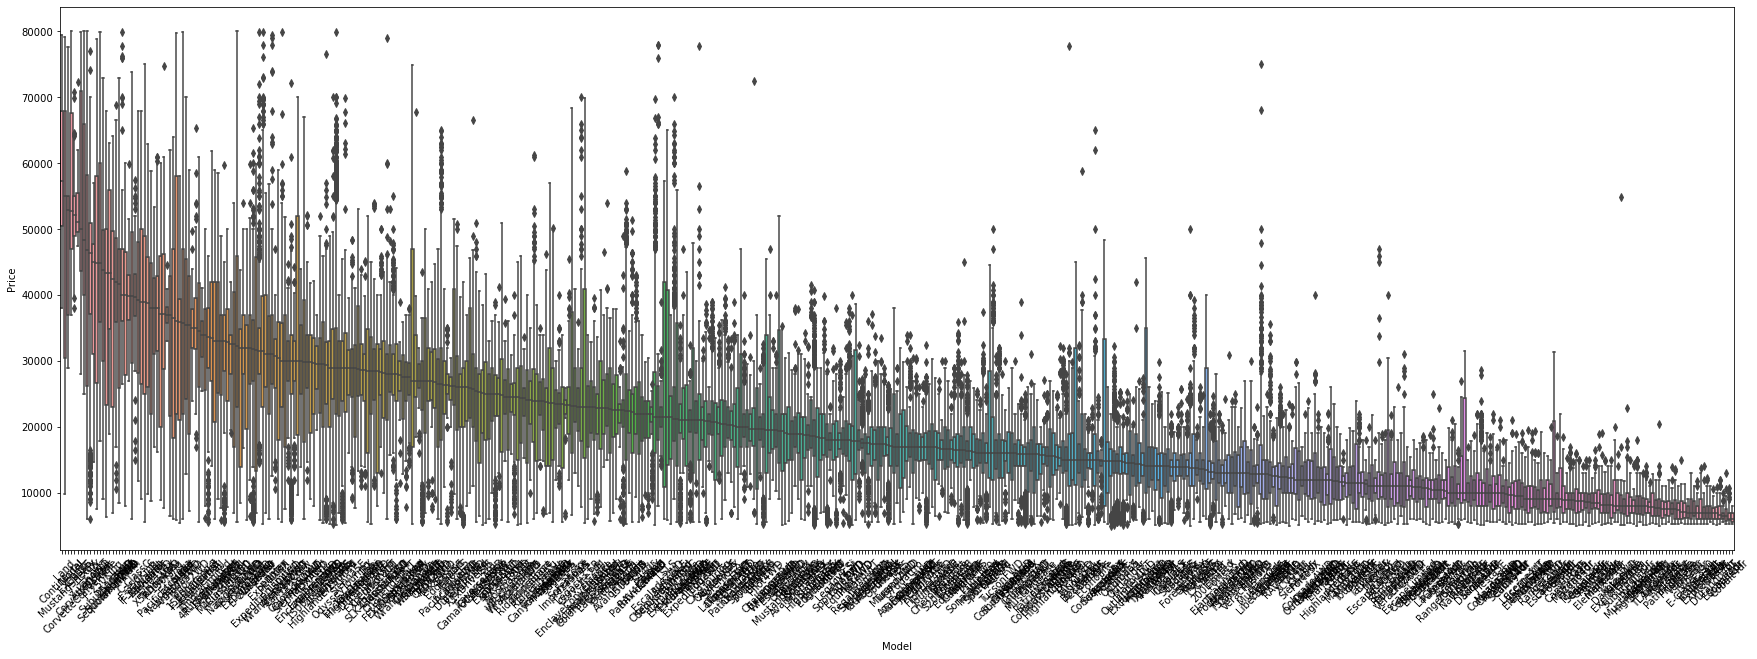

In [13]:
fig, ax = plt.subplots(figsize=(30,10))

violin_order = train_df.groupby("Model")[["Price"]].median().reset_index().sort_values(by="Price", ascending=False)["Model"]

sns.boxplot(data=train_df, x="Model", y="Price", order=violin_order)
plt.xticks(rotation=45);

# Transformacion de datos

In [14]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Make Cluster

c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


{'1': 7, '15002WD': 3, '15004WD': 5, '1500Laramie': 4, '1500Tradesman': 1, '200LX': 7, '200Limited': 7, '200S': 3, '200Touring': 0, '25002WD': 4, '25004WD': 9, '3': 5, '300300C': 8, '300300S': 5, '3004dr': 7, '300Base': 3, '300Limited': 8, '300Touring': 0, '35004WD': 6, '350Z2dr': 0, '4Runner2WD': 4, '4Runner4WD': 4, '4Runner4dr': 0, '4RunnerLimited': 4, '4RunnerRWD': 1, '4RunnerSR5': 1, '4RunnerTrail': 4, '5': 1, '500Pop': 0, '6': 6, '7': 4, '911': 6, '9112dr': 9, 'A34dr': 7, 'A44dr': 7, 'A64dr': 7, 'A8': 6, 'AcadiaAWD': 1, 'AcadiaFWD': 5, 'Accent4dr': 0, 'Accord': 3, 'AccordEX': 3, 'AccordEX-L': 3, 'AccordLX': 3, 'AccordLX-S': 3, 'AccordSE': 7, 'Altima4dr': 0, 'Armada2WD': 1, 'Armada4WD': 6, 'Avalanche2WD': 3, 'Avalanche4WD': 8, 'Avalon4dr': 0, 'AvalonLimited': 5, 'AvalonTouring': 5, 'AvalonXLE': 8, 'Azera4dr': 0, 'Boxster2dr': 3, 'C-Class4dr': 7, 'C-ClassC': 6, 'C-ClassC300': 1, 'C-ClassC350': 5, 'C702dr': 7, 'CC4dr': 7, 'CR-V2WD': 7, 'CR-V4WD': 7, 'CR-VEX': 3, 'CR-VEX-L': 8, 'CR-VL

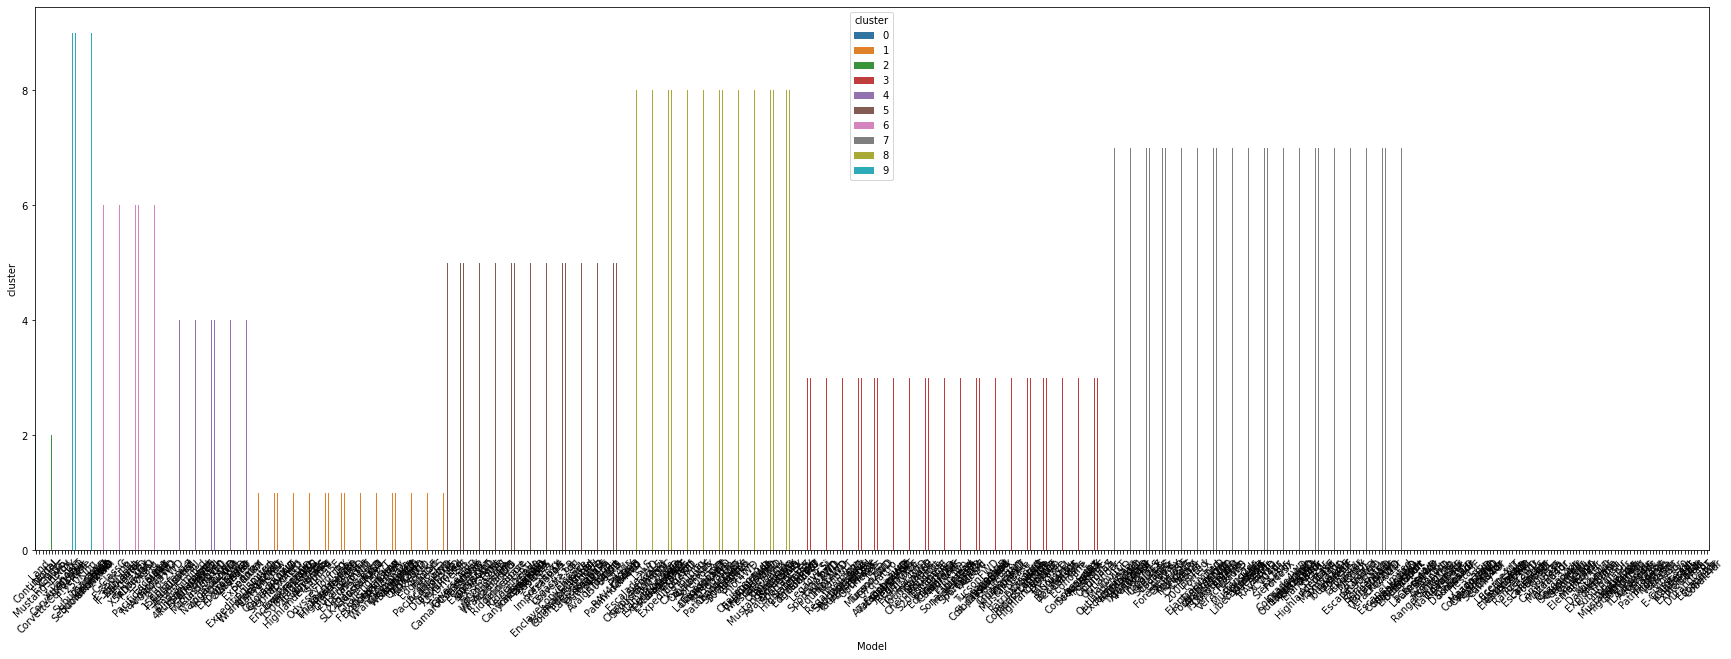

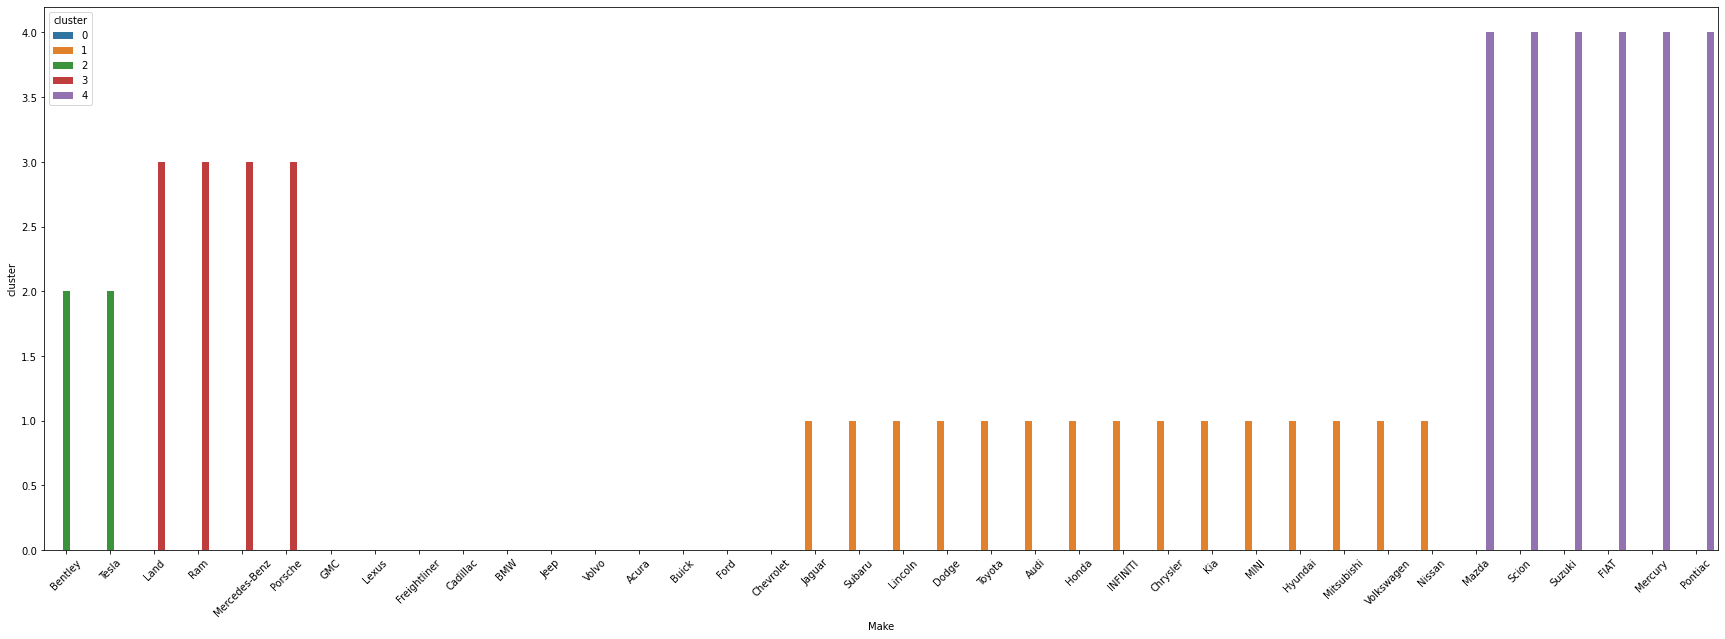

In [15]:
def clusterizar_variables(col, n_clusters):

    kmeans = KMeans(n_clusters=n_clusters, random_state=12)
    encoder = OneHotEncoder()

    price_metric = train_df[[col,"Price"]].groupby([col])["Price"].median().reset_index()


    encoder.fit(price_metric[[col]])
    kmeans_df = price_metric[["Price"]].join(pd.DataFrame(encoder.transform(price_metric[[col]]).toarray()))
    predict = kmeans.fit_predict(kmeans_df)

    kmeans_df["cluster"] = predict

    price_metric = price_metric[[col,"Price"]].join(kmeans_df[["cluster"]])


    order = price_metric.sort_values(by="Price", ascending=False)[col]

    fig, ax = plt.subplots(figsize=(30,10))

    sns.barplot(data=price_metric, x = col, y= "cluster",order=order, hue="cluster",ax=ax)
    plt.xticks(rotation=45);

    dict_clusters = dict(zip(price_metric[col], price_metric["cluster"]))

    return dict_clusters


dict_models = clusterizar_variables(col="Model", n_clusters = 10)
dict_maker = clusterizar_variables(col="Make", n_clusters = 5)
print(dict_models)
print(dict_maker)

In [16]:
dict_maker

{'Acura': 0,
 'Audi': 1,
 'BMW': 0,
 'Bentley': 2,
 'Buick': 0,
 'Cadillac': 0,
 'Chevrolet': 0,
 'Chrysler': 1,
 'Dodge': 1,
 'FIAT': 4,
 'Ford': 0,
 'Freightliner': 0,
 'GMC': 0,
 'Honda': 1,
 'Hyundai': 1,
 'INFINITI': 1,
 'Jaguar': 1,
 'Jeep': 0,
 'Kia': 1,
 'Land': 3,
 'Lexus': 0,
 'Lincoln': 1,
 'MINI': 1,
 'Mazda': 4,
 'Mercedes-Benz': 3,
 'Mercury': 4,
 'Mitsubishi': 1,
 'Nissan': 1,
 'Pontiac': 4,
 'Porsche': 3,
 'Ram': 3,
 'Scion': 4,
 'Subaru': 1,
 'Suzuki': 4,
 'Tesla': 2,
 'Toyota': 1,
 'Volkswagen': 1,
 'Volvo': 0}

In [17]:
categorical_cols = ["Make","Model"]

for c in categorical_cols:
    gr = train_df.groupby(c)[["Price"]].count().reset_index().sort_values(by="Price", ascending = False)
    print(gr.describe())
    print(gr.shape)
    display(gr)

              Price
count     38.000000
mean    6315.789474
std     9358.655506
min        4.000000
25%      619.750000
50%     1933.500000
75%     8011.750000
max    37718.000000
(38, 2)


,Make,Price
10,Ford,37718
6,Chevrolet,34964
35,Toyota,27529
13,Honda,19899
17,Jeep,14683
12,GMC,12511
18,Kia,9889
8,Dodge,9725
14,Hyundai,8957
20,Lexus,8213


              Price
count    525.000000
mean     457.142857
std      816.012440
min       25.000000
25%       88.000000
50%      201.000000
75%      515.000000
max    10789.000000
(525, 2)


,Model,Price
417,Silverado,10789
248,Grand,7474
416,Sierra,4973
40,Accord,4344
187,F-1504WD,3944
...,...,...
339,PathfinderSE,30
515,Yaris4dr,30
383,RegalGS,29
303,Monte,27


In [18]:
X_train_transformed = X_train.copy()

X_train_transformed["cluster_make"] = X_train_transformed["Make"].map(dict_maker).fillna(-1)
X_train_transformed["cluster_model"] = X_train_transformed["Model"].map(dict_models).fillna(-1)
X_train_transformed["Mileage"] = np.log(X_train_transformed["Mileage"])


X_train_transformed = X_train_transformed.drop(columns="Model")


In [19]:
col_dummies = ['Make','State','cluster_make','cluster_model']

encoder = OneHotEncoder(drop='first',handle_unknown='ignore')

encoder.fit(X_train_transformed[col_dummies])

X_train_transformed = pd.concat([X_train_transformed,pd.DataFrame(encoder.transform(X_train_transformed[col_dummies]).toarray(), columns = encoder.get_feature_names_out(), index = X_train_transformed.index)], axis = 1)
X_train_transformed = X_train_transformed.drop(columns=col_dummies)


In [20]:
X_test_transformed = X_test.copy()

X_test_transformed["cluster_make"] = X_test_transformed["Make"].map(dict_maker).fillna(-1)
X_test_transformed["cluster_model"] = X_test_transformed["Model"].map(dict_models).fillna(-1)
X_test_transformed["Mileage"] = np.log(X_test_transformed["Mileage"])


X_test_transformed = X_test_transformed.drop(columns="Model")


In [21]:
col_dummies = ['Make','State','cluster_make','cluster_model']

X_test_transformed = pd.concat([X_test_transformed,pd.DataFrame(encoder.transform(X_test_transformed[col_dummies]).toarray(), columns = encoder.get_feature_names_out(), index = X_test_transformed.index)], axis = 1)
X_test_transformed = X_test_transformed.drop(columns=col_dummies)


In [22]:
X_train_transformed.head()

,Year,Mileage,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,...,cluster_make_4,cluster_model_1,cluster_model_2,cluster_model_3,cluster_model_4,cluster_model_5,cluster_model_6,cluster_model_7,cluster_model_8,cluster_model_9
372565,2017,10.245232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
309294,2016,10.824806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3074,2006,11.758707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
387027,2014,11.091605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
122757,2014,10.605817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
X_test_transformed.head(2)

,Year,Mileage,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,...,cluster_make_4,cluster_model_1,cluster_model_2,cluster_model_3,cluster_model_4,cluster_model_5,cluster_model_6,cluster_model_7,cluster_model_8,cluster_model_9
242160,2010,11.661268,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3413,2014,10.780892,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelo

In [24]:
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

clf = XGBRegressor(random_state=1, tree_method  = "gpu_hist")

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)


mae_XBoost = mean_absolute_error(y_test, y_pred)
rmse_XBoost = np.sqrt(mean_squared_error(y_test, y_pred))


print(mae_XBoost, rmse_XBoost)

2747.198516925049 4133.753747514103


#### Calibracion Hiperparametros

La mejor tasa de aprendizaje para el modelo es igual a 0.5300000000000002


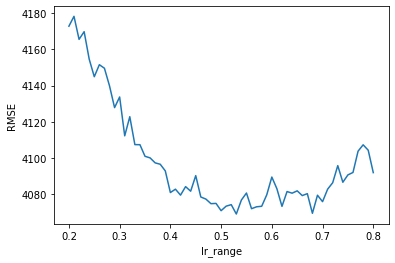

In [292]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
lr_range = np.arange(0.2, 0.8, 0.01)
#lr_range = np.logspace(-5, 0)

# Definición de lista para almacenar el mae y rmse para cada valor de n_estimators
mae_arr = []
rmse_arr = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for lr in lr_range:

    clf = XGBRegressor(random_state=1, learning_rate=lr, tree_method  = "gpu_hist")

    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_arr.append(mae)
    rmse_arr.append(rmse)


    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(lr_range, rmse_arr)
plt.xlabel('lr_range')
plt.ylabel('RMSE')



mensaje = ['La mejor tasa de aprendizaje para el modelo es igual a',str(lr_range[np.argmin(rmse_arr)])]
print(" ".join(mensaje))

In [34]:
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor(learning_rate=0.5300000000000002, random_state=1, tree_method  = "gpu_hist")
parameters = {'nthread':[10], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'max_depth': [2, 3],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [5000,1000,10000]
              }

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)


xgb_grid.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[21:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.5300...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=1,

In [33]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 1000,
 'nthread': 10,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [36]:
y_pred = xgb_grid.best_estimator_.predict(X_test_transformed)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae, rmse)

2737.639107761383 4110.827830950046


La mejor gamma para el modelo es igual a 290000.0


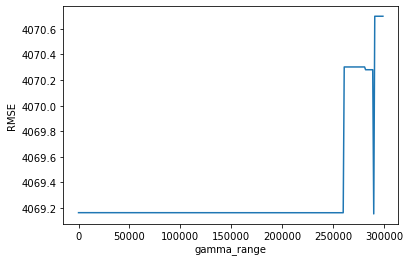

In [294]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
gamma_range = np.arange(0, 300e3, 1000)
#gamma_range = np.logspace(-10, 5, num=20)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
mae_arr = []
rmse_arr = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for gamma in gamma_range:
    clf = XGBRegressor(learning_rate=0.5300000000000002, gamma=gamma, random_state=1, tree_method  = "gpu_hist")
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_arr.append(mae)
    rmse_arr.append(rmse)
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_range, rmse_arr)
plt.xlabel('gamma_range')
plt.ylabel('RMSE')

mensaje = ['La mejor gamma para el modelo es igual a',str(gamma_range[np.argmin(rmse_arr)])]
print(" ".join(mensaje))

In [296]:
rmse_arr[np.argmin(rmse_arr)]

4069.1543609270548

In [297]:
from sklearn.ensemble import BaggingRegressor

bgr = BaggingRegressor(n_estimators=10, n_jobs=-1, random_state=12)

bgr.fit(X_train_transformed, y_train)
y_pred = bgr.predict(X_test_transformed)


mae_bgr = mean_absolute_error(y_test, y_pred)
rmse_bgr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_bgr, rmse_bgr)


2903.3793422591275 4461.006146245196


In [37]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=0,max_depth = 2, n_estimators=200)

rfr.fit(X_train_transformed, y_train)
y_pred = rfr.predict(X_test_transformed)


mae_rfr = mean_absolute_error(y_test, y_pred)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_rfr, rmse_rfr)

6369.06535164611 8722.692229538407


In [298]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

clf = XGBRegressor(learning_rate=0.5300000000000002, random_state=1, tree_method  = "gpu_hist")
bgr = BaggingRegressor(n_estimators=10, n_jobs=-1, random_state=12)

estimators = [
    ("bgr", make_pipeline(bgr)),
    ("xgb" , make_pipeline(clf)),
    ]
stk = StackingRegressor(estimators=estimators, n_jobs=-1) 
stk.fit(X_train_transformed, y_train)

y_pred = stk.predict(X_test_transformed)

In [299]:
mae_rfr = mean_absolute_error(y_test, y_pred)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_rfr, rmse_rfr)

2679.7913869095773 4064.991284110966


# Preparacion kaggle

In [304]:
kaggle_df = pd.read_csv("../INPUT/dataTest_carListings.csv")

In [305]:
kaggle_transformed = kaggle_df.copy()

kaggle_transformed["cluster_make"] = kaggle_transformed["Make"].map(dict_maker).fillna(-1)
kaggle_transformed["cluster_model"] = kaggle_transformed["Model"].map(dict_models).fillna(-1)
kaggle_transformed["Mileage"] = np.log(kaggle_transformed["Mileage"])


kaggle_transformed = kaggle_transformed.drop(columns="Model")

col_dummies = ['Make','State','cluster_make','cluster_model']

kaggle_transformed = pd.concat([kaggle_transformed,pd.DataFrame(encoder.transform(kaggle_transformed[col_dummies]).toarray(), columns = encoder.get_feature_names_out(), index = kaggle_transformed.index)], axis = 1)
kaggle_transformed = kaggle_transformed.drop(columns=col_dummies)


In [307]:
y_pred_kaggle = stk.predict(kaggle_transformed.drop(columns="ID"))

kaggle_transformed["Price"] = y_pred_kaggle

In [1]:
col_export_kaggle = ["ID","Price"]

kaggle_transformed[col_export_kaggle].to_csv("../OUTPUT/prediccion_base.csv", index=False)

NameError: name 'kaggle_transformed' is not defined